# Spark: pierwszy kontakt


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, Word2Vec
from pyspark import SparkContext
import matplotlib.pyplot as plt
from time import time
import random
import re

In [2]:
import os

def get_cwd():
    cwd = os.getcwd()
    if not cwd.endswith('lab5'):
        return os.path.join(cwd, 'lab5')
    return cwd

# Przykład

In [3]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
sc = spark.sparkContext

def inside(p):
    x, y = random.random(), random.random()
    return x*x + y*y < 1

NUM_SAMPLES = 10000000

count = sc.parallelize(range(0, NUM_SAMPLES)).filter(inside).count()
print("Pi is roughly %f" % (4.0 * count / NUM_SAMPLES))

spark.stop()

25/05/05 14:24:23 WARN Utils: Your hostname, Mateuszs-MacBook-Pro-M3-Pro.local resolves to a loopback address: 127.0.0.1; using 10.129.5.99 instead (on interface en0)
25/05/05 14:24:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/05 14:24:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Pi is roughly 3.141998


# Zadanie 1 – całkowanie Monte Carlo
Korzystając z API RDD napisz krótki skrypt, który policzy całkę oznaczoną z x2+1 w zakresie od 0 do 2
korzystając z metody Monte Carlo (czyli w praktyce wylosuje dużo punktów w pewnym prostokącie,
sprawdzi ile z nich znalazło się pod wykresem funkcji, oraz przemnoży ten ułamek przez pole
prostokąta). Porównaj uzyskany wynik z rozwiązaniem analitycznym (jeżeli nie pamiętamy jak się
całkowało – to można je dostać np. na WolframAlpha…). Można inspirować się podobnym
przykładem dla obliczania liczby pi (https://spark.apache.org/examples.html ).

In [4]:
def f(x):
    return x**2 + 1

def monte_carlo_integration(spark, num_samples=1000000):
    # Create RDD of random points
    f2 = f(2)
    points = spark.sparkContext.parallelize(range(num_samples))
    
    # Generate random x and y coordinates
    # x is between 0 and 2
    # y is between 0 and 5 (since f(2) = 5 is the maximum in our range)
    random_points = points.map(lambda _: (random.uniform(0, 2), random.uniform(0, f2)))
    
    # Count points under the curve
    points_under_curve = random_points.filter(lambda point: point[1] <= f(point[0])).count()
    
    # Calculate the integral
    # Area of the rectangle is width * height = 2 * 5 = 10
    # Integral = (points_under_curve / total_points) * rectangle_area
    rectangle_area = 2 * f2  # width = 2, height = 5
    integral = (points_under_curve / num_samples) * rectangle_area
    
    return integral

In [5]:
# Create Spark session
spark = SparkSession.builder \
    .appName("MonteCarloIntegration") \
    .getOrCreate()

# Number of samples
num_samples = 10000000

# Calculate integral using Monte Carlo
start_time = time()
result = monte_carlo_integration(spark, num_samples)
end_time = time()

# Analytical solution: integral of x² + 1 from 0 to 2
# ∫(x² + 1)dx = (x³/3 + x) evaluated from 0 to 2
# = (8/3 + 2) - (0 + 0) = 14/3 ≈ 4.6667
analytical_solution = 14/3

print(f"Monte Carlo result: {result:.6f}")
print(f"Analytical solution: {analytical_solution:.6f}")
print(f"Error: {abs(result - analytical_solution):.6f}")
print(f"Time taken: {end_time - start_time:.2f} seconds")

# Stop Spark session
spark.stop()

Monte Carlo result: 4.665550
Analytical solution: 4.666667
Error: 0.001117
Time taken: 1.26 seconds


## Obliczenia analityczne

$\int_{0}^{2} (x^2 + 1) \, dx = \left[ \frac{x^3}{3} + x \right]_{0}^{2}$

$= \left( \frac{2^3}{3} + 2 \right) - \left( \frac{0^3}{3} + 0 \right)$

$= \left( \frac{8}{3} + 2 \right) - 0$

$= \frac{8}{3} + \frac{6}{3} = \frac{14}{3} \approx 4.6667$

# Zadanie 2 – statystyka porównawcza tekstów
Wraz z instrukcją dostarczono również spore pliki tekstowe, zawierające dwa dzieła literackie które
na zawsze zmieniły oblicze Europy. Porównaj statystykę występujących w nich charakterystycznych
słów. Dla każdej z ksiąg wypisz 20 najczęściej występujących w niej słów, spośród tych, których
częstotliwość występowania w danym dziele jest przynajmniej 5 razy większa niż w drugim z nich
(bierzemy pod uwagę tylko słowa występujące w obu księgach).
Konieczne będzie wczytanie tekstów z plików, ich podział na słowa, sprowadzenie wszystkich do
lowercase, wyczyszczenie (usunięcie cyfr czy znaków przestankowych), policzenie częstotliwości
wystąpień, odfiltrowanie tych spełniających zadany warunek, a na koniec wypisanie wyniku.
Korzystamy z API RDD.


In [6]:
def clean_text(text):
    return re.sub(r'[^a-zA-Z\s]', '', text.lower())

def process_text_file(sc, file_path):
    rdd = (sc.textFile(file_path)
            .flatMap(lambda line: clean_text(line).split())
            .filter(lambda word: len(word) > 0))
    
    total_words = rdd.count()
    
    word_counts = (rdd
                  .map(lambda word: (word, 1))
                  .reduceByKey(lambda a, b: a + b)
                  .collectAsMap())
    
    return word_counts, total_words

def get_significant_words(word_counts1, total1, word_counts2, total2, min_ratio=5.0):
    common_words = set(word_counts1) & set(word_counts2)
    
    significant_words = []
    for word in common_words:
        freq1 = word_counts1[word] / total1
        freq2 = word_counts2[word] / total2
        
        if freq2 > 0:
            ratio = freq1 / freq2
            if ratio >= min_ratio:
                significant_words.append((word, word_counts1[word], ratio))
    
    return sorted(significant_words, key=lambda x: x[2], reverse=True)[:20]

def print_results(title, words):
    print(f"\n{title}")
    print("-" * len(title))
    for word, count, ratio in words:
        print(f"{word:15} {count:>6} (ratio: {ratio:.1f}x)")

In [7]:
# Initialize Spark
sc = SparkContext("local", "TextComparison")

# Get current directory path
current_dir = get_cwd()

# Process both texts with absolute paths
bible_path = os.path.join(current_dir, "the_king_james_bible.txt")
manifesto_path = os.path.join(current_dir, "the_communist_manifesto.txt")

bible_counts, bible_total = process_text_file(sc, bible_path)
manifesto_counts, manifesto_total = process_text_file(sc, manifesto_path)

# Get significant words for each text
bible_significant = get_significant_words(bible_counts, bible_total, manifesto_counts, manifesto_total)
manifesto_significant = get_significant_words(manifesto_counts, manifesto_total, bible_counts, bible_total)

# Print results
print_results(
    "Top 20 words in Bible (at least 5x more frequent than in Manifesto)",
    bible_significant
)
print_results(
    "Top 20 words in Communist Manifesto (at least 5x more frequent than in Bible)",
    manifesto_significant
)

sc.stop()


Top 20 words in Bible (at least 5x more frequent than in Manifesto)
-------------------------------------------------------------------
shall             9838 (ratio: 142.1x)
lord              7830 (ratio: 113.1x)
i                 8854 (ratio: 64.0x)
said              3999 (ratio: 57.8x)
came              2093 (ratio: 30.2x)
he               10419 (ratio: 15.1x)
come              1971 (ratio: 14.2x)
forth              888 (ratio: 12.8x)
give               880 (ratio: 12.7x)
him               6659 (ratio: 12.0x)
jerusalem          811 (ratio: 11.7x)
whom               763 (ratio: 11.0x)
went              1400 (ratio: 10.1x)
before            1796 (ratio: 8.7x)
hundred            590 (ratio: 8.5x)
saw                548 (ratio: 7.9x)
people            2139 (ratio: 7.7x)
make              1056 (ratio: 7.6x)
voice              505 (ratio: 7.3x)
cast               501 (ratio: 7.2x)

Top 20 words in Communist Manifesto (at least 5x more frequent than in Bible)
-----------------------------

# Zadanie 3 – wizualizacja rozkładu słów w tekstach
Na koniec prześledzimy rozkład chmury słów w obu dokumentach, korzystając z API DataFrame i
gotowych rozwiązań z MLlib. Zrobimy to w następujący sposób:
* wczytamy oba teksty dzieląc je po kropkach na zdania
* scalimy je następnie do jednego DF
* użyjemy RegexTokenizera by podzielić zdania na słowa
* użyjemy StopWordsRemovera by usunąć słowa nieistotne semantycznie
* użyjemy algorytmu Word2Vec by każdemu ze słów przypisać (na podstawie kontekstu w
którym występowało) dwuwymiarowy wektor je reprezentujący
* wyniki zapiszemy do pliku w postaci trzech kolumn (z której książki pochodziło słowo –
wartość pierwszej współrzędnej wektora – wartość drugiej współrzędnej wektora)
* zwizualizujemy dowolnym narzędziem pozwalającym na rysowanie scatter plots
* efekt powinien być podobny jak poniżej




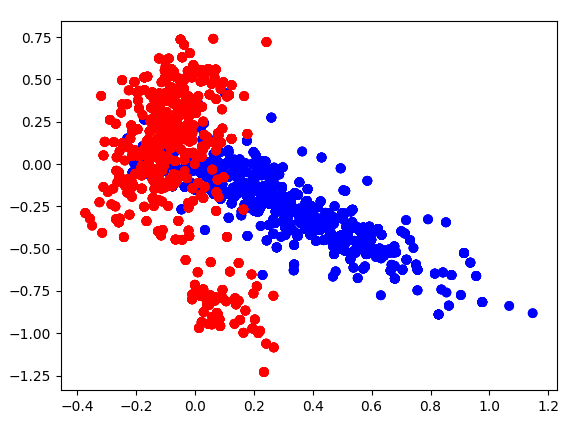

Saved word2vec_scatter.csv with columns: source, x, y


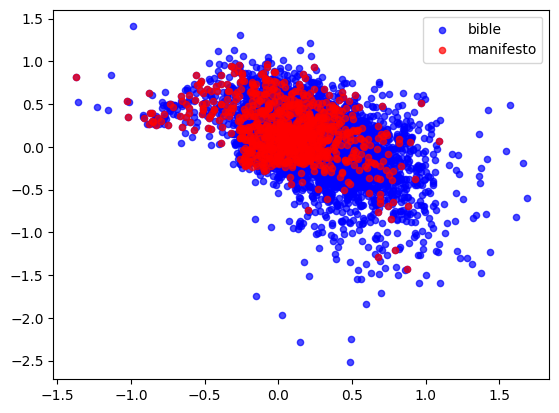

In [47]:
spark = SparkSession.builder.master("local[*]").appName("Word2VecViz").getOrCreate()

def read_sentences(path, label):
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
    sentences = [s.strip() for s in text.split(".") if s.strip()]
    return [(label, s) for s in sentences]

bible_path = os.path.join(get_cwd(), "the_king_james_bible.txt")
manifesto_path = os.path.join(get_cwd(), "the_communist_manifesto.txt")

bible_data = read_sentences(bible_path, "bible")
manifesto_data = read_sentences(manifesto_path, "manifesto")

data = bible_data + manifesto_data
df = spark.createDataFrame(data, ["source", "sentence"])

tokenizer = RegexTokenizer(inputCol="sentence", outputCol="words", pattern="\\W+")
df_words = tokenizer.transform(df)

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_filtered = remover.transform(df_words)

word2vec = Word2Vec(vectorSize=2, minCount=5, inputCol="filtered", outputCol="features")
model = word2vec.fit(df_filtered)
words_df = model.getVectors()

exploded = df_filtered.select("source", explode("filtered").alias("word"))
exploded = exploded.dropDuplicates(["source", "word"])

result = exploded.join(words_df, exploded.word == words_df.word, "inner") \
    .select(exploded.source, words_df.word, words_df.vector)

result_pd = result.toPandas()
result_pd["x"] = result_pd["vector"].apply(lambda v: float(v[0]))
result_pd["y"] = result_pd["vector"].apply(lambda v: float(v[1]))
result_pd[["source", "x", "y"]].to_csv(os.path.join(get_cwd(), "word2vec_scatter.csv"), index=False)

print("Saved word2vec_scatter.csv with columns: source, x, y")

try:
    import matplotlib.pyplot as plt
    colors = {"bible": "blue", "manifesto": "red"}
    for src, group in result_pd.groupby("source"):
        plt.scatter(group["x"], group["y"], c=colors[src], label=src, alpha=0.7, s=20)
    plt.legend()
    plt.show()
except ImportError:
    print("matplotlib not installed, skipping plot.")

spark.stop()

# Nie wiem jak mam coś zrobić – jak żyć?
Prowadzący powinien rozpocząć zajęcia od krótkiego wstępu. Będzie on pobieżnym streszczenie oficjalnych materiałów szkoleniowych od Apache. W szczególności zaś:
* https://spark.apache.org/docs/latest/quick-start.html (szybki start ze Sparkiem)
* https://spark.apache.org/docs/latest/rdd-programming-guide.html (wprowadzenie do RDD)
* https://spark.apache.org/docs/latest/sql-programming-guide.html (wprowadzenie do DataFrames)
* https://spark.apache.org/docs/latest/ml-guide.html (wprowadzenie do MLliba)
* oraz najważniejszego, czyli dokumentacji samego API - https://spark.apache.org/docs/latest/api/python/pyspark.html

P.S. Nie martw się, jeżeli nie zdążysz zrobić wszystkich zadań – zostały przygotowane „na zapas”, na wypadek gdyby ich rozwiązywanie szło bardzo szybko.